# **NGƯỜI THỰC HIỆN:**
**STUDENT ID:** 20120547

**STUDENT NAME:** VÕ THÀNH PHONG

**EMAIL:** 20120547@student.hcmus.edu.vn

# Mở đầu
- Trong file .ipynb này, em sẽ trình các bước cài đặt các mô hình của mình để giải quyết bài toán phân loại được yêu cầu.
- Để tổng thể được gọn gàng và dễ hiểu, file này chỉ trình bày code cài đặt và một vài giải thích cũng như nhận xét tổng quan cho các bước thực hiện, mô tả chi tiết về mặt lý thuyết sẽ được trình bày trong file báo cáo kèm theo.

# Import các thư viện cần thiết

In [1]:
# Pytorch
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

# Image Augumentation
import torchvision.transforms.functional as TF

# Data Visulization
import matplotlib.pyplot as plt

# OpenCV
import cv2

# Data processing
import os
import numpy as np
import random

# Splitting Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Model SVM
from sklearn import svm

In [2]:
#Cài đặt thư viện mahotas để trích xuất đặc trưng
!pip install mahotas==1.4.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mahotas: filename=mahotas-1.4.8-cp310-cp310-linux_x86_64.whl size=5248913 sha256=d2faf3999558d96d63f62a99db5f30b2480d1f2384346f7c339528f85d4d40dc
  Stored in directory: /root/.cache/pip/wheels/e8/73/1c/25215779be11aeb31d0fdd8e351c1b089e27d8cf23154fa46f
Successfully built mahotas


In [3]:
#Thư viện cho việc feature extraction
import mahotas as mt

In [4]:
#import thư viện để tải dataset được lưu săn trên google drive
import gdown

In [5]:
#Tải file nén dataset và giải nén
url = 'https://drive.google.com/uc?id=1vpcAkq7PoGf1xzXLAVfVgqI2xP0gMfhc'
output = 'plant-pathology-2020-fgvc7.zip'
gdown.download(url, output, quiet=False)
!unzip plant-pathology-2020-fgvc7.zip

Downloading...
From: https://drive.google.com/uc?id=1vpcAkq7PoGf1xzXLAVfVgqI2xP0gMfhc
To: /content/plant-pathology-2020-fgvc7.zip
100%|██████████| 817M/817M [00:04<00:00, 168MB/s]


Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [6]:
csv_train_file_path='./train.csv'
csv_test_file_path='./test.csv'
file_path='./images'
images_name=os.listdir(file_path)
images_name[:5]

['Train_1721.jpg',
 'Test_973.jpg',
 'Test_1081.jpg',
 'Train_682.jpg',
 'Train_544.jpg']

# Cái nhìn tổng quan về các loại bệnh

Thực hiện thống kê trên tập dữ liệu huấn luyện về số lượng mẫu thuộc về từng lớp.

In [7]:
train_df = pd.read_csv(csv_train_file_path)
count_by_attr = train_df.iloc[:, 1:].sum()

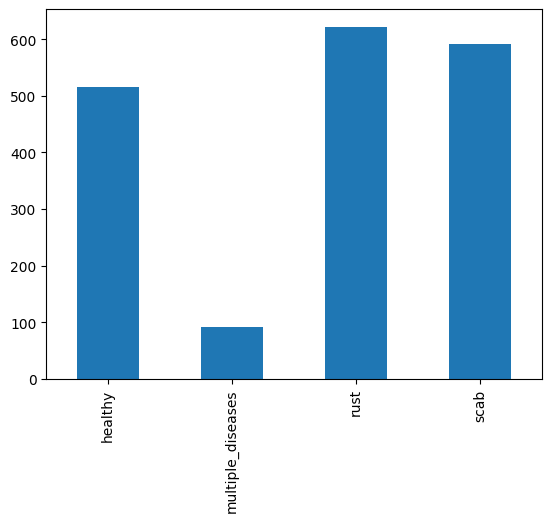

In [8]:
#vẽ bar chart thống kê số lượng mẫu thuộc về từng lớp
count_by_attr.plot(kind = 'bar');

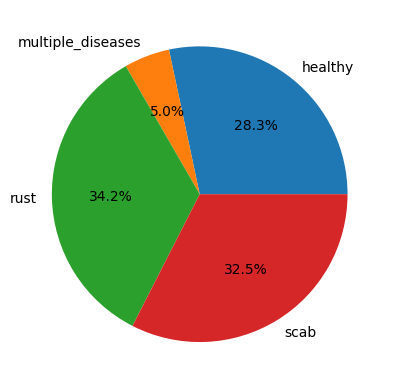

In [9]:
#vẽ pie chart thống kê phần trăm của mỗi lớp
count_by_attr.plot(kind='pie',autopct='%1.1f%%', ylabel='');

# Tạo dataset bằng cách trích xuất đặc trưng
- Hai loại đặc trưng mà em sẽ sử dụng để phân loại bằng SVM trong bài làm này của mình là:
  + Color Features: là các giá trị trung bình và độ lệch chuẩn của toàn bộ các pixel trong từng kênh màu sắc của ảnh.
  + Texture Features: là các đặc trưng về cấu trúc ảnh được nhà khoa học **Haralick** đưa ra trong thuật toán Haralick (thuật toán được đặt theo tên ông).
- Trình bày tổng quan thuật toán sẽ được trình bày trong bản báo cáo kèm theo.
- Các bước thực hiện trích xuất đặc trưng như sau:
  + Đối với color features: Từ ảnh màu ban đầu, em sẽ tách các kênh màu của ảnh một cách riêng biệt, và trên mỗi kênh màu em sẽ tính trung bình và độ lệch chuẩn cho các pixel của kênh đó.
  + Đối với texture features:
    * Từ ảnh màu ban đầu phải chuyển ảnh sang ảnh xám, do thuật toán Haralick được thực hiện trên các cặp pixel của ảnh xám.
    * Dùng thư viện **mahotas** có sẵn để hỗ trợ lấy các đặc trưng về cấu trúc theo thuật toán Haralick.
- Sau khi có được ma trận đặc trưng mới cho toàn bộ ảnh của dataset ban đầu, em sẽ tiến hành huấn luyện và đánh giá với các mô hình của mình.
- Để dễ dàng làm việc ta quy định thứ tự các lớp như sau:
  + healthy: 0
  + multiple_diseases: 1
  + rust: 2
  + scab: 3

In [10]:
def create_dataset(file_path, df,train=True):
    """
    Parameters:
    ----------
    csv_train_file_path: đường dẫn đến file csv chứa kết quả nhãn cho các mẫu tập train.
    file_path: đường dẫn đến nơi lưu các ảnh.
    df: dataframe chứa thông tin từ file .csv
    train: biến boolean để xác định tạo dataset cho việc train hay huấn luyện.
    """
    
    columns_name = ['mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b',
                    'contrast','correlation', 'inverse_difference_moments', 'entropy']
    data = pd.DataFrame([], columns=columns_name)
    
    for i in range(len(df)):
        imgpath = file_path + '/' + df.loc[i, 'image_id'] + '.jpg'
        main_img = cv2.imread(imgpath)
        rgb_img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(rgb_img, (512,512)) #giảm kích thước
        
        #Preprocessing
        
        # Convert to HSV color space
        hsv = cv2.cvtColor(main_img, cv2.COLOR_BGR2HSV)
        # Define range of leaf's color in HSV
        lower_green = np.array([36, 25, 25])
        upper_green = np.array([95, 255, 255])
        lower_yellow = np.array([20, 25, 25])
        upper_yellow = np.array([35, 255, 255])
        lower_brown = np.array([10, 25, 25])
        upper_brown = np.array([20, 255, 255])
        # Threshold the HSV image to get only leaf's colors
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
        mask_gy = cv2.bitwise_or(mask_green, mask_yellow)
        mask = cv2.bitwise_or(mask_gy, mask_brown)
        # Apply the mask to the original image
        result = cv2.bitwise_and(main_img, main_img, mask=mask)
        img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        gs = cv2.cvtColor(resized_img,cv2.COLOR_RGB2GRAY)
        
        
        # Trích xuất Color features
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        r_channel[r_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        g_channel[g_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        b_channel[b_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        
        red_mean = np.mean(r_channel)
        green_mean = np.mean(g_channel)
        blue_mean = np.mean(b_channel)
        
        red_std = np.std(r_channel)
        green_std = np.std(g_channel)
        blue_std = np.std(b_channel)
        
        #Trích xuất Texture features
        textures = mt.features.haralick(gs)
        ht_mean = textures.mean(axis=0)
        contrast = ht_mean[1]
        correlation = ht_mean[2]
        inverse_diff_moments = ht_mean[4]
        entropy = ht_mean[8]
        
        vector = [red_mean,green_mean,blue_mean,red_std,green_std,blue_std,
                  contrast,correlation,inverse_diff_moments,entropy]
        
        df_temp = pd.DataFrame([vector],columns=columns_name)
        data = pd.concat([data, df_temp], axis=0)
    
    #bước tạo vector chứa các nhãn
    if train==True:
        y_train=np.array([np.argmax(df.loc[i,df.columns[1:]].values) for i in range(len(df))])
    
    #Chuyển dataframe sang mảng numpy
    X=data.to_numpy()
    
    #split thành tập train và tập validation
    if train==True:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y_train,test_size=0.2, random_state=82)
        return X_train, X_valid, y_train, y_valid
    else:
        return X

In [11]:
train_df=pd.read_csv(csv_train_file_path)

In [12]:
X_train, X_valid, y_train, y_valid=create_dataset(file_path, train_df)

# Xây dựng mô hình Support Vector Machine
- Trong việc sử dụng SVM để phân loại lần này, em sẽ sử dụng nhiều loại kernel khác nhau để có thể tìm được mô hình SVM hiệu quả nhất cũng như so sánh kết quả khi chạy trên các kernel khác nhau sẽ như thế nào.
- Các kernel được sử dụng là:
  + LinearSVC (linear kernel).
  + SVC with RBF kernel.
  + SVC with polynomial kernel (degree = 3).

Nhưng trước hết cần phải thực hiện feature scaling để đưa các giá trị của các thuộc tính về một phân phối chuẩn tốt hơn cho việc huấn luyện.

In [13]:
#thực hiện bước feature scaling
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [15]:
C = 100  # SVM regularization parameter
lin_svm = svm.SVC(kernel='linear', gamma=1.5, tol=0.001, C=C, probability=True).fit(X_train, y_train)
rbf_svm = svm.SVC(kernel='rbf', decision_function_shape='ovr',
                  degree=3, gamma=1.5, tol=0.001, C=C, probability=True).fit(X_train, y_train)
poly_svm = svm.SVC(kernel='poly', degree=3, C=C, tol=0.001, probability=True).fit(X_train, y_train)

In [16]:
train_acc_scores, valid_acc_scores=[], []
for s in [lin_svm, rbf_svm, poly_svm]:
    train_acc_scores.append(accuracy_score(y_train, s.predict(X_train)))
    valid_acc_scores.append(accuracy_score(y_valid, s.predict(X_valid)))

In [17]:
kers=['linear SVM', 'rbf SVM', 'poly SVM']
for i in range(len(kers)):
    print('with '+kers[i]+':')
    print('Train accuracy: ', train_acc_scores[i])
    print('Valid accuracy: ', valid_acc_scores[i])
    print('---------------------------')

with linear SVM:
Train accuracy:  0.49793956043956045
Valid accuracy:  0.5150684931506849
---------------------------
with rbf SVM:
Train accuracy:  0.9993131868131868
Valid accuracy:  0.5095890410958904
---------------------------
with poly SVM:
Train accuracy:  0.6675824175824175
Valid accuracy:  0.4712328767123288
---------------------------


**Nhận xét chung:**
- Mô hình SVM đạt độ chính xác thấp kể cả trên tập train và tập test.
- Điều này là do việc dùng mô hình SVM cần có các giá trị số cho các thuộc tính làm đầu vào, việc trích xuất thuộc tính chỉ liên quan đến phần chiếc lá bị bệnh ở trung tâm bức ảnh gặp khó khăn với bộ dữ liệu này.
- **Lý do gặp khó khăn là do:**
  + Bức ảnh không tồn tại duy nhất một chiếc lá mà có rất nhiều chiếc lá khác xung quanh cũng như rất nhiều chiếc lá trong bức ảnh rõ nét hoăc mờ khác nhau từ vào việc nó ở xa hay gần trong lúc chụp.
  + Nếu chiếc lá độc lập trên một nền có màu hoàn toàn thì việc tập trung trích xuất các đặc trưng số cho chiếc lá là khả thi hơn nhiều.
  + Lá bị bệnh đôi khi có chi tiết về bệnh rất ít cũng như màu sắc đốm bệnh gần tương đồng với màu lá cũng gây khó khăn rất nhiều cho việc lấy được thông tin đúng khi trích xuất các đặc trưng về màu sắc cũng như cấu trúc chiếc lá.
- **Nếu có thời gian xin thầy giành chút ít thời gian ghé thăm mô hình của em được áp dụng trên một bộ dataset ảnh lá cây khác, đó chính là bộ dataset khá nổi tiếng có tên 'PlantVillage'. Tại đây em sẽ minh chứng được những khó khăn mà mình vừa nêu trên do mô hình khi áp dụng trên tập dataset 'PlantVillage' đạt accuracy là 85%.**
- Link notebook cho mô hình áp dụng trên PlantVillage:
https://colab.research.google.com/drive/1sKs5bw21cDzcNQMa_W0wvRzp3jvF99Vl?usp=sharing

**Tuy nhiên em cũng có suy nghĩ để có thể cải tiến hết mức mô hình của mình trên bộ dữ liệu 'plant-pathology' này**.

- Nếu khó khăn liên quan đến việc bức ảnh có quá nhiều nhiễu, màu nền khó phân tách với vật thể lá, hay độ mờ/nét của lá trong ảnh, .... Thì việc khắc phục chắc chắn sẽ là tập trung vào vấn đề lấy được đoạn hình ảnh quan trọng về lá cây bị bệnh.
- Nhận thấy tất cả các tấm ảnh đều sẽ có một lá ở trung tâm, lá này sẽ chứa tình trạng cho tất cả lá khác nếu cùng có mặt trong ảnh, vậy **ta sẽ cố gắng lấy thông tin của chỉ trên chiếc lá ở trung tâm ảnh này**.

(Giải thích các bước chi tiết sẽ được trình bày trong file báo cáo đính kèm).

# Cải tiến việc trích xuất đặc trưng và mô hình SVM

In [18]:
def crop_center_image(image):
    image=cv2.resize(image,(512,512))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    M = cv2.moments(gray)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Tính toán kích thước và vị trí của vùng ảnh bạn muốn cắt ra từ ảnh gốc
    w = 128
    h = 128
    x = cx - w // 2
    y = cy - h // 2

    # Kiểm tra xem vùng ảnh cắt ra có vượt quá kích thước của ảnh gốc hay không
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if x + w > gray.shape[1]:
        w = gray.shape[1] - x
    if y + h > gray.shape[0]:
        h = gray.shape[0] - y

    # Cắt vùng ảnh từ ảnh gốc và chuyển sang grayscale
    center = image[y:y+h, x:x+w]
    return center

In [19]:
def create_dataset_with_crop_center(file_path, df,train=True):
    """
    Parameters:
    ----------
    csv_train_file_path: đường dẫn đến file csv chứa kết quả nhãn cho các mẫu tập train.
    file_path: đường dẫn đến nơi lưu các ảnh.
    df: dataframe chứa thông tin từ file .csv
    train: biến boolean để xác định tạo dataset cho việc train hay huấn luyện.
    """
    
    columns_name = ['mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b',
                    'contrast','correlation', 'inverse_difference_moments', 'entropy']
    data = pd.DataFrame([], columns=columns_name)
    
    for i in range(len(df)):
        imgpath = file_path + '/' + df.loc[i, 'image_id'] + '.jpg'
        main_img = cv2.imread(imgpath)
        center=crop_center_image(main_img)
        rgb_img = cv2.cvtColor(center, cv2.COLOR_BGR2RGB)
        
        gs = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2GRAY)
        
        
        #Color features
        r_channel = rgb_img[:,:,0]
        g_channel = rgb_img[:,:,1]
        b_channel = rgb_img[:,:,2]
        r_channel[r_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        g_channel[g_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        b_channel[b_channel == 255] = 0 #loại bỏ các pixel có nền trắng và chỉ giữ lại các pixel có màu.
        
        red_mean = np.mean(r_channel)
        green_mean = np.mean(g_channel)
        blue_mean = np.mean(b_channel)
        
        red_std = np.std(r_channel)
        green_std = np.std(g_channel)
        blue_std = np.std(b_channel)
        
        #Texture features
        textures = mt.features.haralick(gs)
        ht_mean = textures.mean(axis=0)
        contrast = ht_mean[1]
        correlation = ht_mean[2]
        inverse_diff_moments = ht_mean[4]
        entropy = ht_mean[8]
        
        vector = [red_mean,green_mean,blue_mean,red_std,green_std,blue_std,
                  contrast,correlation,inverse_diff_moments,entropy]
        
        df_temp = pd.DataFrame([vector],columns=columns_name)
        data = pd.concat([data, df_temp], axis=0)
    
    #bước tạo vector chứa các nhãn
    if train==True:
        y_train=np.array([np.argmax(df.loc[i,df.columns[1:]].values) for i in range(len(df))])
    
    #Chuyển dataframe sang mảng numpy
    X=data.to_numpy()
    
    #split thành tập train và tập validation
    if train==True:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y_train,test_size=0.2, random_state=82)
        return X_train, X_valid, y_train, y_valid
    else:
        return X

In [20]:
train_df=pd.read_csv(csv_train_file_path)

In [21]:
X_train, X_valid, y_train, y_valid=create_dataset_with_crop_center(file_path, train_df)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [23]:
C = 100  # SVM regularization parameter
lin_svm = svm.SVC(kernel='linear', gamma=0.1, tol=0.001, C=C, probability=True).fit(X_train, y_train)
rbf_svm = svm.SVC(kernel='rbf', decision_function_shape='ovr',
                  degree=3, gamma=0.1, tol=0.001, C=C, probability=True).fit(X_train, y_train)
poly_svm = svm.SVC(kernel='poly', degree=3, C=C, tol=0.001, probability=True).fit(X_train, y_train)

In [24]:
train_acc_scores, valid_acc_scores=[], []
for s in [lin_svm, rbf_svm, poly_svm]:
    train_acc_scores.append(accuracy_score(y_train, s.predict(X_train)))
    valid_acc_scores.append(accuracy_score(y_valid, s.predict(X_valid)))

In [25]:
kers=['linear SVM', 'rbf SVM', 'poly SVM']
for i in range(len(kers)):
    print('with '+kers[i]+':')
    print('Train accuracy: ', train_acc_scores[i])
    print('Valid accuracy: ', valid_acc_scores[i])
    print('---------------------------')

with linear SVM:
Train accuracy:  0.6016483516483516
Valid accuracy:  0.6219178082191781
---------------------------
with rbf SVM:
Train accuracy:  0.8660714285714286
Valid accuracy:  0.6356164383561644
---------------------------
with poly SVM:
Train accuracy:  0.7307692307692307
Valid accuracy:  0.6164383561643836
---------------------------


**Dự đoán trên tập Test với 3 kernel**

In [26]:
test_df=pd.read_csv(csv_test_file_path)
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [27]:
X_test=create_dataset_with_crop_center(file_path, test_df, train=False)

In [28]:
X_test = scaler.transform(X_test)

In [29]:
probs_rbf = rbf_svm.predict_proba(X_test)
softmax_rbf = np.exp(probs_rbf) / np.sum(np.exp(probs_rbf), axis=1, keepdims=True)
probs_linear = lin_svm.predict_proba(X_test)
softmax_linear = np.exp(probs_linear) / np.sum(np.exp(probs_linear), axis=1, keepdims=True)
probs_poly = poly_svm.predict_proba(X_test)
softmax_poly = np.exp(probs_poly) / np.sum(np.exp(probs_poly), axis=1, keepdims=True)

In [30]:
def create_submission(softmax, test_df):
    submission_df = softmax.copy()
    submission_df=pd.DataFrame(submission_df,columns=['healthy','multiple_diseases','rust','scab'])
    submission_df['image_id'] = list(test_df.image_id.values)
    submission_df = submission_df[['image_id','healthy','multiple_diseases','rust','scab']]
    return submission_df

In [31]:
submission_rbf_df = create_submission(softmax_rbf,test_df)
submission_linear_df = create_submission(softmax_linear,test_df)
submission_poly_df = create_submission(softmax_poly,test_df)

In [32]:
submission_rbf_df.to_csv('submission-svm-rbfKernel.csv', index=False)
submission_linear_df.to_csv('submission-svm-linearKernel.csv', index=False)
submission_poly_df.to_csv('submission-svm-polyKernel.csv', index=False)

**Việc sử dụng mô hình học máy như SVM cho việc phân lớp ảnh cũng đã gặp khó khăn chưa kể đến việc bài toán được đưa ra ở đây lại là phân loại nhiều lớp. Với sự kết hợp của quá trình trích xuất đặc trưng cũng đã giúp cải thiện phần nào độ chính xác của mô hình.**

**Sau đây sẽ là ý tưởng mở rộng khi áp dụng mạng CNN vào phân loại bộ dữ liệu plant-pathology mà cụ thể là kiến trúc VGG16.**

# Xây dựng kiến trúc VGG16

**Data Augmentation:**
- Vấn đề dữ liệu trong các mô hình deep learning là rất quan trọng, do đó sử dụng data augmentation để tăng cường dữ liệu cho quán trình huấn luyện là cần thiết.
- Vì sao chọn data augmentation?
  + Augmentation là các đơn giản, dễ thực hiện và ít tốn chi phí nếu muốn tăng cường dữ liệu bằng việc thực hiện xoay hình, lật hình, thêm hoạt cảnh thời tiết, ....
  + Thực hiện nhanh chóng và thực hiện ngay trên dataset đang có sẵn trong tay.

In [33]:
# data_transforms cho việc tăng cường dữ liệu
training_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30)]
)
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True)]
)

Để minh họa cho việc tăng cường dữ liệu bằng data augmentation. Em sẽ trực quan ảnh 'Test_82.jpg' và các biến thể sinh ra từ nó thông qua Data Augmentation.

Không có gì đặc biệt trong việc chọn ảnh, chỉ là thực hiện chọn ngẫu nhiên và 8/2 là sinh nhật của em ^_^

In [34]:
#thư việc hỗ trợ đọc ảnh thuận tiên hợn
from PIL import Image

(-0.5, 2047.5, 1364.5, -0.5)

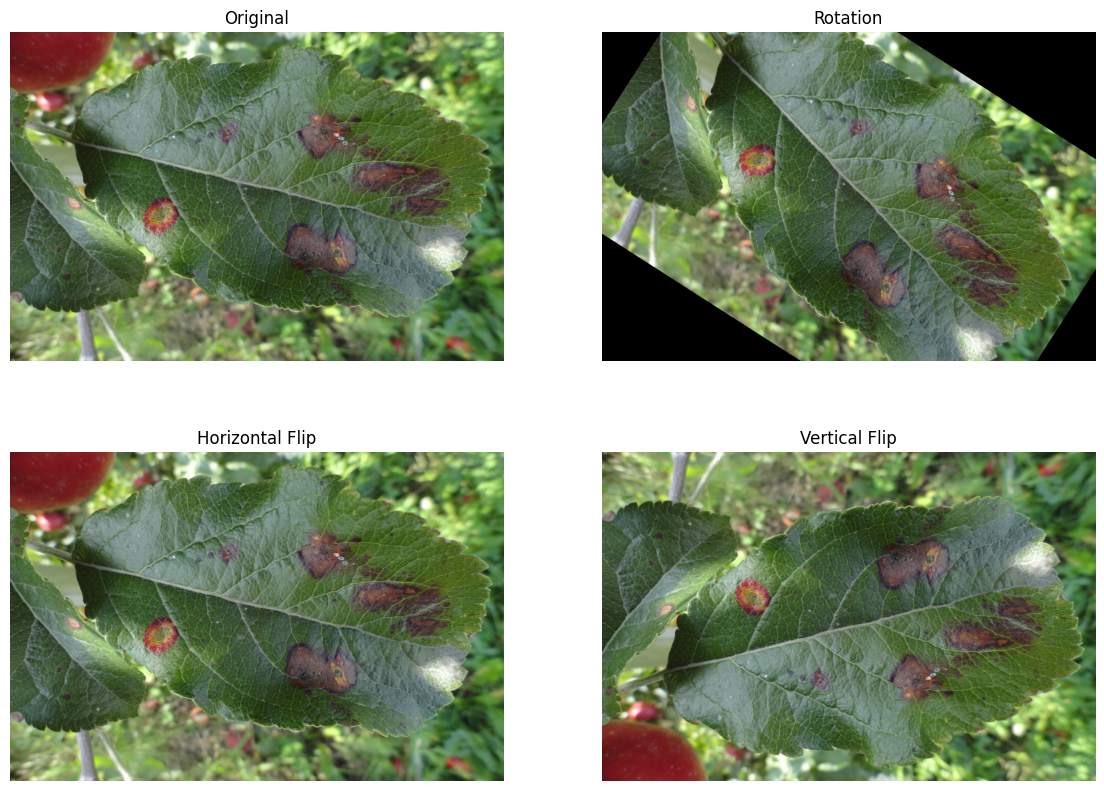

In [35]:
img_leaf = Image.open('./images/Test_82.jpg').convert('RGB')

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)

# Ảnh gốc.
plt.imshow(img_leaf)
plt.title(f"Original", fontsize=12)
plt.axis("off")

# Xoay 45 độ.
plt.subplot(2, 2, 2)
img_rotation = transforms.RandomRotation(degrees= 45)(img_leaf)
plt.imshow(img_rotation)
plt.title(f"Rotation", fontsize=12)
plt.axis("off")

# lật ảnh theo chiều ngang.
plt.subplot(2, 2, 3)
img_horizon = transforms.RandomHorizontalFlip()(img_leaf)
plt.imshow(img_horizon)
plt.title(f"Horizontal Flip", fontsize=12)
plt.axis("off")

# Lật ảnh theo chiều dọc.
plt.subplot(2, 2, 4)
img_vertical = transforms.RandomVerticalFlip()(img_leaf)
plt.imshow(img_vertical)
plt.title(f"Vertical Flip", fontsize=12)
plt.axis("off")

**Xây dựng một lớp custom dataset cho việc load dữ liệu:**

In [36]:
class MyDataset(Dataset):
    def __init__(self, file_path, df, transforms=None, training=True):
        self.df = df
        self.transforms = transforms
        self.training = training
        self.Path_to_image=file_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.Path_to_image + '/' + self.df.loc[idx, 'image_id'] + '.jpg'
        img = Image.open(img_path).convert('RGB')
        if self.training:
            labels = np.argmax(self.df.loc[idx,self.df.columns[1:]].values)
            labels =torch.as_tensor(labels, dtype=torch.int8)
            if self.transforms:
                img = self.transforms(img)
            return img, labels
        else:
            if self.transforms:
                img = self.transforms(img)
            return img
        return img

**Xây dựng model và tiến hành training:**

In [37]:
def get_model(num_classes = 4):
    model = models.vgg16(pretrained = True)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features= in_features, out_features=num_classes)
    return model

def train_model(model, 
                training_data_loader, 
                valid_data_loader, 
                critertion,
                optimizer,
                num_epochs = 5,
                device = None):
    min_loss = np.inf
    valid_loss_history = []
    valid_acc_history = []
    training_loss_history = []
    training_acc_history = []
    
    for epoch in range(1, num_epochs + 1):
        print("Epoch %d/%d: " %(epoch, num_epochs))
        training_loss = 0
        valid_loss = 0
        running_loss = 0
        model.train()
        step = 1
        preds_accuracy = []
        labels_accuracy = []
        for images, labels in training_data_loader:
            if device is not None:
                images = images.to(device)
                labels = labels.type(torch.LongTensor)  
                labels = labels.to(device)
                
            #Dự đoán bằng model
            predictions = model(images)

            #Xóa bộ nhớ gradient của Pytorch
            optimizer.zero_grad()
            
            #Tính chi phí Loss 
            training_loss_step =  critertion(predictions, labels)
            training_loss_step.backward()

            #Cập nhật tham số bằng gradient descent trong Pytorch
            optimizer.step()
            training_loss  += training_loss_step.item()
            running_loss = training_loss/step
            step +=1

            labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
            preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        training_loss_history.append(training_loss)
        training_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        training_acc_history.append(training_accuracy)
        print("Training loss: %.3f  Accuracy: %.3f" %(training_loss, training_accuracy))

        step =1 # reset step for validation
        preds_accuracy = []
        labels_accuracy = []
        model.eval() # Gọi hàm đánh giá của model

        #Trong bước đánh giá không cần thực hiện gradient descent để cập nhật tham số
        #Do đó không cần gọi đến grad() của Pytorch
        with torch.no_grad():
            for images, labels in valid_data_loader:
                if device is not None:
                    images = images.to(device)
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                
                
                predictions = model(images)
                valid_loss_step = critertion(predictions, labels)
                valid_loss += valid_loss_step.item()

                running_loss = valid_loss/step
                step+=1
                labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
                preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)

        valid_loss_history.append(valid_loss)
        valid_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        valid_acc_history.append(valid_accuracy)
        print("Valid loss: %.3f     Accuracy: %.3f" % (valid_loss, valid_accuracy))
        if valid_loss <= min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(),'./classifier-vgg16.pth')
            print("Model save with %.3f loss at Epoch %d" % (min_loss, epoch))
        print('\n===========================================================')
        print("Complete epoch %d/%d     Training loss: %.3f     Trainning accuracy: %.3f   Valid loss: %.3f    Valid accuracy: %.3f"\
                        %(epoch, num_epochs, training_loss,training_accuracy, valid_loss, valid_accuracy))
        print('============================================================')

    return training_loss_history,training_acc_history, valid_loss_history,valid_acc_history

Đọc dữ liệu từ file 'train.csv' để làm đầu vào cho lớp MyDataset

In [38]:
train_df = pd.read_csv(csv_train_file_path)

In [39]:
training_data, valid_data = train_test_split(train_df,test_size=0.35, random_state=82)

In [40]:
training_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [41]:
training_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_962,0,0,1,0
1,Train_1692,0,0,0,1
2,Train_458,0,0,1,0
3,Train_861,0,0,0,1
4,Train_117,0,0,1,0


In [42]:
valid_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_1811,0,0,1,0
1,Train_724,0,0,1,0
2,Train_59,0,0,1,0
3,Train_740,0,0,0,1
4,Train_1732,0,0,1,0


In [43]:
training_dataset = MyDataset(file_path, training_data, transforms= training_transforms, training=True)
valid_dataset = MyDataset(file_path, valid_data, transforms=valid_transforms, training=True)

In [44]:
training_data_loader = DataLoader(training_dataset, batch_size=16)
valid_data_loader = DataLoader(valid_dataset, batch_size=8)

In [45]:
#Tạo khung cho model
model = get_model(num_classes = 4)
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 306MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
url = 'https://drive.google.com/uc?id=1zIP10ACKPHbbb2Ke6a0XNbKIEFWrOL5r'
output = 'classifier-vgg16.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zIP10ACKPHbbb2Ke6a0XNbKIEFWrOL5r
To: /content/classifier-vgg16.pth
100%|██████████| 537M/537M [00:05<00:00, 106MB/s] 


'classifier-vgg16.pth'

In [47]:
#Tải mô hình đã được pre-trained sẵn bộ tham số tối ưu vào khung vừa tạo phía trên
if torch.cuda.is_available():
    model.load_state_dict(torch.load('./classifier-vgg16.pth'))
else:
    model.load_state_dict(torch.load('./classifier-vgg16.pth', map_location=torch.device('cpu')))

In [48]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
critertion = nn.CrossEntropyLoss()
num_epochs = 15

In [49]:
history = train_model(model, 
                    training_data_loader, 
                    valid_data_loader,
                    critertion,
                    optimizer,
                    num_epochs,
                    device)

Epoch 1/15: 
Training loss: 16.564  Accuracy: 0.941
Valid loss: 7.146     Accuracy: 0.976
Model save with 7.146 loss at Epoch 1

Complete epoch 1/15     Training loss: 16.564     Trainning accuracy: 0.941   Valid loss: 7.146    Valid accuracy: 0.976
Epoch 2/15: 
Training loss: 10.829  Accuracy: 0.956
Valid loss: 9.749     Accuracy: 0.976

Complete epoch 2/15     Training loss: 10.829     Trainning accuracy: 0.956   Valid loss: 9.749    Valid accuracy: 0.976
Epoch 3/15: 
Training loss: 9.085  Accuracy: 0.970
Valid loss: 7.067     Accuracy: 0.981
Model save with 7.067 loss at Epoch 3

Complete epoch 3/15     Training loss: 9.085     Trainning accuracy: 0.970   Valid loss: 7.067    Valid accuracy: 0.981
Epoch 4/15: 
Training loss: 9.809  Accuracy: 0.957
Valid loss: 9.715     Accuracy: 0.964

Complete epoch 4/15     Training loss: 9.809     Trainning accuracy: 0.957   Valid loss: 9.715    Valid accuracy: 0.964
Epoch 5/15: 
Training loss: 10.202  Accuracy: 0.959
Valid loss: 9.928     Accura

**Đánh giá:**

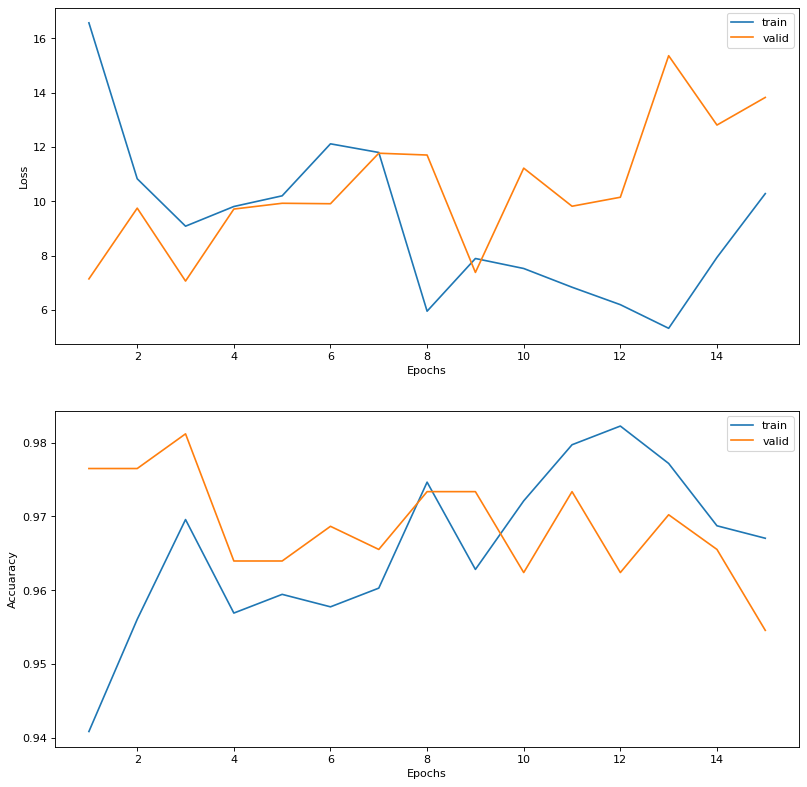

In [50]:
loss, acc, val_loss, val_acc = history
plt.figure(figsize=(12, 12), dpi=80)
plt.subplot(2,1,1)
plt.plot([i for i in range(1,len(loss)+1)],loss)
plt.plot([i for i in range(1,len(loss)+1)], val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(2,1,2)
plt.plot([i for i in range(1,len(loss)+1)],acc)
plt.plot([i for i in range(1,len(loss)+1)], val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuaracy')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

**Dự đoán trên tập Test:**

In [51]:
test_df = pd.read_csv(csv_test_file_path)
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [52]:
test_dataset= MyDataset(file_path, test_df,transforms=valid_transforms, training=False)
test_data_loader = DataLoader(test_dataset, batch_size= 32)

In [53]:
result =pd.DataFrame()
for imgs in test_data_loader:
    imgs = imgs.to(device)
    predictions = model(imgs)
    score = nn.Softmax(1)(predictions).detach().cpu().numpy()
    output = pd.DataFrame(score, columns=['healthy','multiple_diseases','rust','scab'])
    result = pd.concat([result, output], ignore_index=True)

In [54]:
submission_df = result.copy()
submission_df['image_id'] = test_df.image_id
submission_df = submission_df[['image_id','healthy','multiple_diseases','rust','scab']]

submission_df.to_csv('submission-vgg16.csv', index=False)